In [4]:
%load_ext rpy2.ipython

import pandas as pd
from metasub_utils.packet_parse import MetaSUBTableFactory
from capalyzer.packet_parser.experimental import umap
import warnings
from os.path import isfile

warnings.filterwarnings('ignore')

dupe_tabler = MetaSUBTableFactory.duplicate_factory()
core_tabler = MetaSUBTableFactory.core_factory()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
%%R

library(ggthemes)
library(ggplot2)
library(reshape2)
library(gridExtra)
library(ALDEx2)
library(RColorBrewer)

In [8]:
dupe_map = pd.read_csv(dupe_tabler.packet_dir + '/metadata/duplicate_map.csv', index_col=0)
dupe_map.head()

,uuid_primary,uuid_secondary,ha_id
430,haib17CEM4890_HKC32ALXX_SL254763,haib17KIU4866_H7HJMCCXY_SL272762,4890-CEM-0091
432,haib17CEM4890_HKC32ALXX_SL254680,haib17KIU4866_H7HJMCCXY_SL272763,4890-CEM-0008
434,haib17CEM4890_HKC32ALXX_SL254692,haib17KIU4866_H7HJMCCXY_SL272764,4890-CEM-0020
436,haib17CEM4890_HKC32ALXX_SL254704,haib17KIU4866_H7HJMCCXY_SL272765,4890-CEM-0032
438,haib17CEM4890_HKC32ALXX_SL254716,haib17KIU4866_H7HJMCCXY_SL272766,4890-CEM-0044


In [24]:
primary = core_tabler.taxonomy(normalize=True).loc[dupe_map['uuid_primary'].tolist()]
secondary = dupe_tabler.taxonomy(normalize=True)
primary['ha_id'] = dupe_map.set_index('uuid_primary')['ha_id']
primary['uuid'] = primary.index
secondary['ha_id'] = dupe_map.set_index('uuid_secondary')['ha_id']
secondary['uuid'] = secondary.index
dupe_taxa = pd.concat([primary, secondary])
dupe_taxa = dupe_taxa.melt(id_vars=['ha_id', 'uuid'])
dupe_taxa.head()

,ha_id,uuid,variable,value
0,4890-CEM-0091,haib17CEM4890_HKC32ALXX_SL254763,16SrX (Apple proliferation group),0.0
1,4890-CEM-0008,haib17CEM4890_HKC32ALXX_SL254680,16SrX (Apple proliferation group),0.0
2,4890-CEM-0020,haib17CEM4890_HKC32ALXX_SL254692,16SrX (Apple proliferation group),0.0
3,4890-CEM-0032,haib17CEM4890_HKC32ALXX_SL254704,16SrX (Apple proliferation group),NaN
4,4890-CEM-0044,haib17CEM4890_HKC32ALXX_SL254716,16SrX (Apple proliferation group),NaN


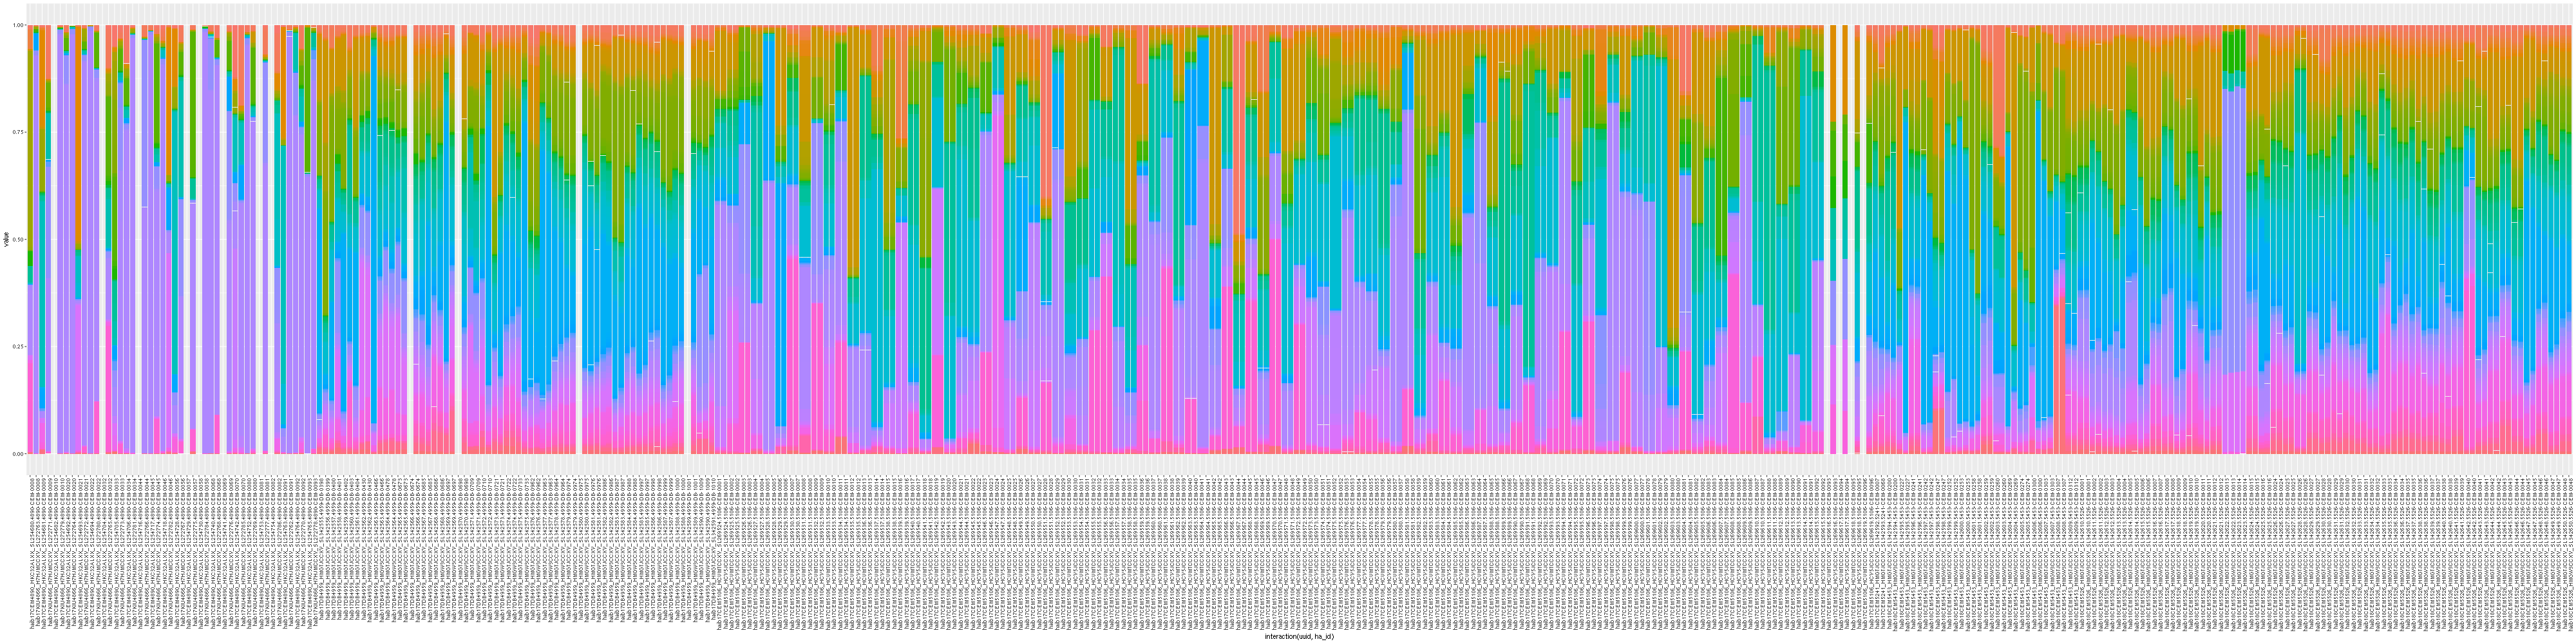

In [28]:
%%R -i dupe_taxa -w 4000 -h 1000


ggplot(dupe_taxa, aes(x=interaction(uuid, ha_id), y=value, fill=variable)) +
    geom_col() +
    theme(
        legend.position='none',
        axis.text.x = element_text(angle = 90, hjust = 1),
    )

In [35]:
primary = core_tabler.taxonomy(normalize=True).loc[dupe_map['uuid_primary'].tolist()]
secondary = dupe_tabler.taxonomy(normalize=True)
primary['ha_id'] = dupe_map.set_index('uuid_primary')['ha_id']
primary['uuid'] = primary.index
secondary['ha_id'] = dupe_map.set_index('uuid_secondary')['ha_id']
secondary['uuid'] = secondary.index
dupe_taxa = pd.concat([primary, secondary])
taxa = (dupe_taxa.fillna(0).drop(columns=['ha_id', 'uuid']) > 0)

In [55]:
u = umap(taxa, n_neighbors=100)
u['ha_id'] = dupe_taxa['ha_id']
u.head()

,C0,C1,ha_id
haib17CEM4890_HKC32ALXX_SL254763,6.364096,49.185719,4890-CEM-0091
haib17CEM4890_HKC32ALXX_SL254680,12.152545,26.950729,4890-CEM-0008
haib17CEM4890_HKC32ALXX_SL254692,12.291839,27.038549,4890-CEM-0020
haib17CEM4890_HKC32ALXX_SL254704,6.003500,48.408783,4890-CEM-0032
haib17CEM4890_HKC32ALXX_SL254716,6.978572,48.505962,4890-CEM-0044


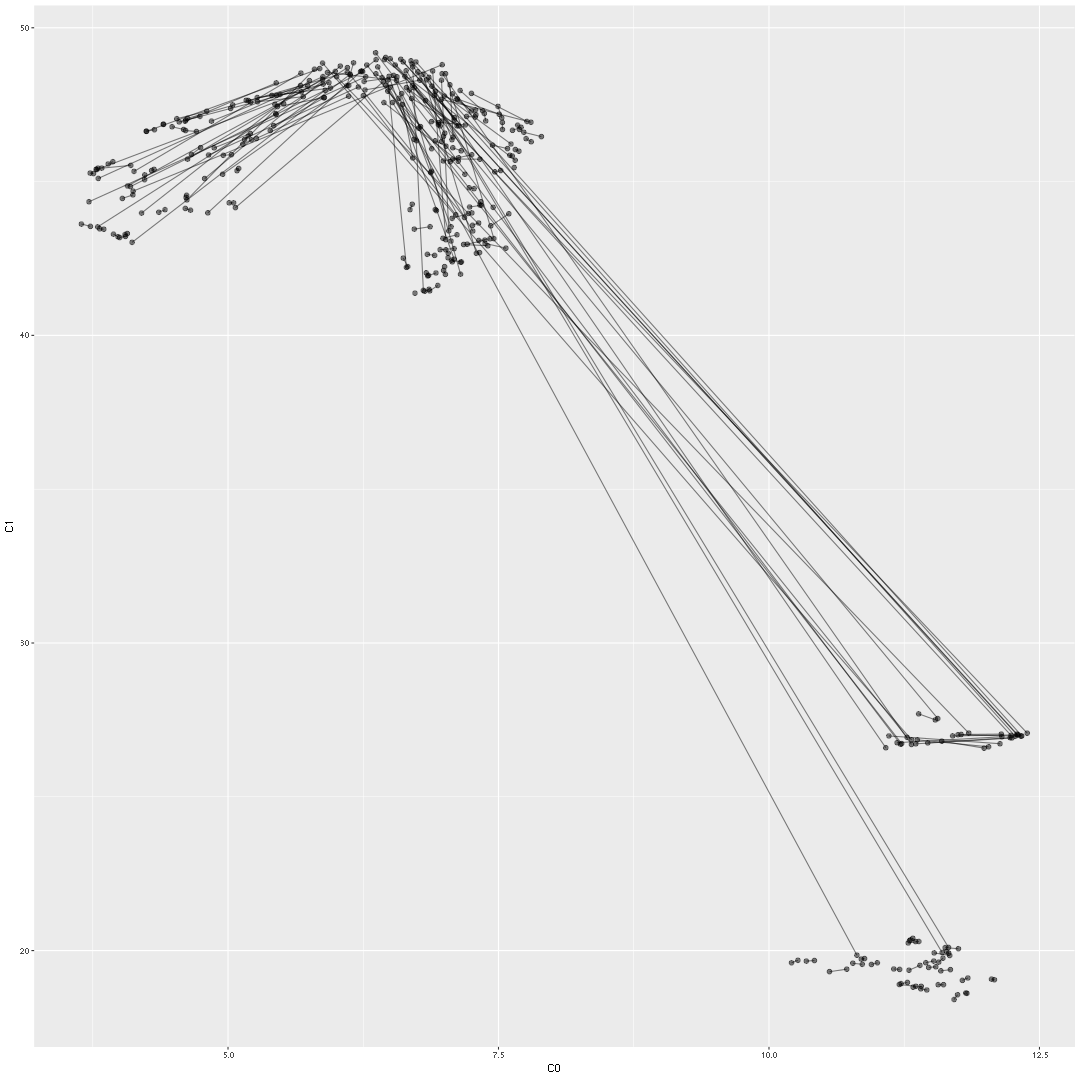

In [58]:
%%R -i u -w 1080 -h 1080

ggplot(u, aes(x=C0, y=C1, group=ha_id)) +
    geom_line(alpha=0.5) +
    geom_point(alpha=0.5, size=2)

In [73]:
ha_ids = dupe_taxa['ha_id']
d = core_tabler.beta_diversity(taxa, metric='jaccard')
d['v1'] = d.index
d = d.melt(id_vars=['v1'])
d['h1'] = d['v1'].map(lambda el: ha_ids[el])
d['h2'] = d['variable'].map(lambda el: ha_ids[el])
d = d.query('v1 != variable')
d['same'] = d.apply(lambda r: 'same' if r['h1'] == r['h2'] else 'different', axis=1)
d.head()

,v1,variable,value,h1,h2,same
1,haib17CEM4890_HKC32ALXX_SL254680,haib17CEM4890_HKC32ALXX_SL254763,0.655285,4890-CEM-0008,4890-CEM-0091,different
2,haib17CEM4890_HKC32ALXX_SL254692,haib17CEM4890_HKC32ALXX_SL254763,0.663551,4890-CEM-0020,4890-CEM-0091,different
3,haib17CEM4890_HKC32ALXX_SL254704,haib17CEM4890_HKC32ALXX_SL254763,1.000000,4890-CEM-0032,4890-CEM-0091,different
4,haib17CEM4890_HKC32ALXX_SL254716,haib17CEM4890_HKC32ALXX_SL254763,1.000000,4890-CEM-0044,4890-CEM-0091,different
5,haib17CEM4890_HKC32ALXX_SL254728,haib17CEM4890_HKC32ALXX_SL254763,0.505972,4890-CEM-0056,4890-CEM-0091,different


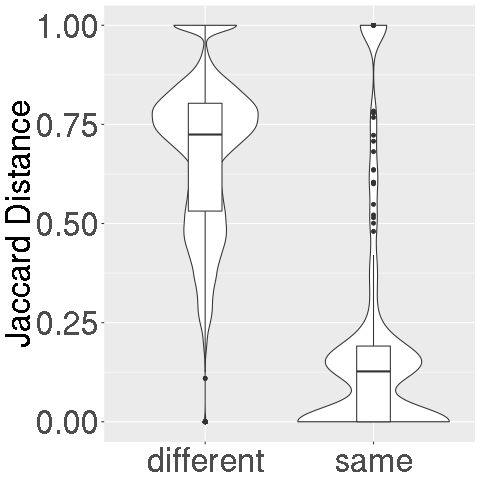

In [83]:
%%R -i d

ggplot(d, aes(x=same, y=value)) +
    geom_violin() +
    geom_boxplot(width=0.2) +

    ylab('Jaccard Distance') +
    theme(
        text = element_text(size=40),
        axis.title.x=element_blank()
    )